# Reto Housing Kaggle

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [321]:
train_data = "data/train.csv"
test_data = "data/test.csv"
df_train = pd.read_csv(train_data)

## Exploración

### Util functions

In [322]:
def plot_hist_per_columns(df, cols):
    N = 15 if len(cols) > 1 else 5
    fig, axs = plt.subplots(1, len(cols), figsize=(N, 5))
    if isinstance(axs, str):
        axs = [axs]
    for i, col in enumerate(cols):
        axs[i].hist(df[col])
        axs[i].set_title(col)
        axs[i].grid()
    fig.tight_layout()

def plot_scatter_per_columns(df, cols):
    N = 15 if len(cols) > 1 else 5
    fig, axs = plt.subplots(1, len(cols), figsize=(N, 5))
    if isinstance(axs, str):
        axs = [axs]
    for i, col in enumerate(cols):
        axs[i].scatter(df[col], df["SalePrice"])
        axs[i].set_title(col)
        axs[i].grid()
    fig.tight_layout()

def plot_box_per_columns(df, cols):
    N = 15 if len(cols) > 1 else 5
    fig, axs = plt.subplots(1, len(cols), figsize=(N, 5))
    if isinstance(axs, str):
        axs = [axs]
    
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(cols)))

    for i, col in enumerate(cols):
        data = df[col].dropna().values
        axs[i].boxplot([data], vert=True, patch_artist=True, notch=True, showfliers=False, boxprops=dict(color=colors[i]))
        axs[i].set_title(col)
        axs[i].grid()
    fig.tight_layout()

def plot_hist_scatter_per_columns(df, col):
    N = 15
    fig, axs = plt.subplots(1, 2, figsize=(N, 5))
    axs[0].set_title(f'Histogram of {col}')
    axs[0].hist(df[col])
    axs[0].grid()
    axs[1].set_title(f'Scatterplot of {col} vs SalePrice')
    axs[1].scatter(df[col], df["SalePrice"])
    axs[1].grid()
    fig.tight_layout()

In [323]:
def shapiro_wilk_test(data, print_results=True):
    statistic, pvalue = shapiro(data)
    if print_results:
        print(f"Shapiro-Wilk test statistic: {statistic:.4f}")
        print(f"p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        if print_results:
            print("The data is not normally distributed. \n")
        return False
    else:
        if print_results:
            print("The data is normally distributed. \n")
        return True

### Exploratory

In [324]:
missing_perc = df_train.isna().mean() * 100
missing_selected = missing_perc[missing_perc > 40]

missing_selected = missing_selected.apply(lambda x: "% " + str(round(x, 2)))

if (missing_perc > 0).any():
    print(missing_selected)
else:
    print("No missing values")

print()

if (df_train.duplicated().any()):
    print("Data has duplicated values.")
else:
    print("Data has no duplicated values.")

Alley          % 93.77
MasVnrType     % 59.73
FireplaceQu    % 47.26
PoolQC         % 99.52
Fence          % 80.75
MiscFeature     % 96.3
dtype: object

Data has no duplicated values.


In [325]:
porch_cols = [col for col in df_train.columns if "porch" in col.lower()]
print(*porch_cols, sep="\n")

OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch


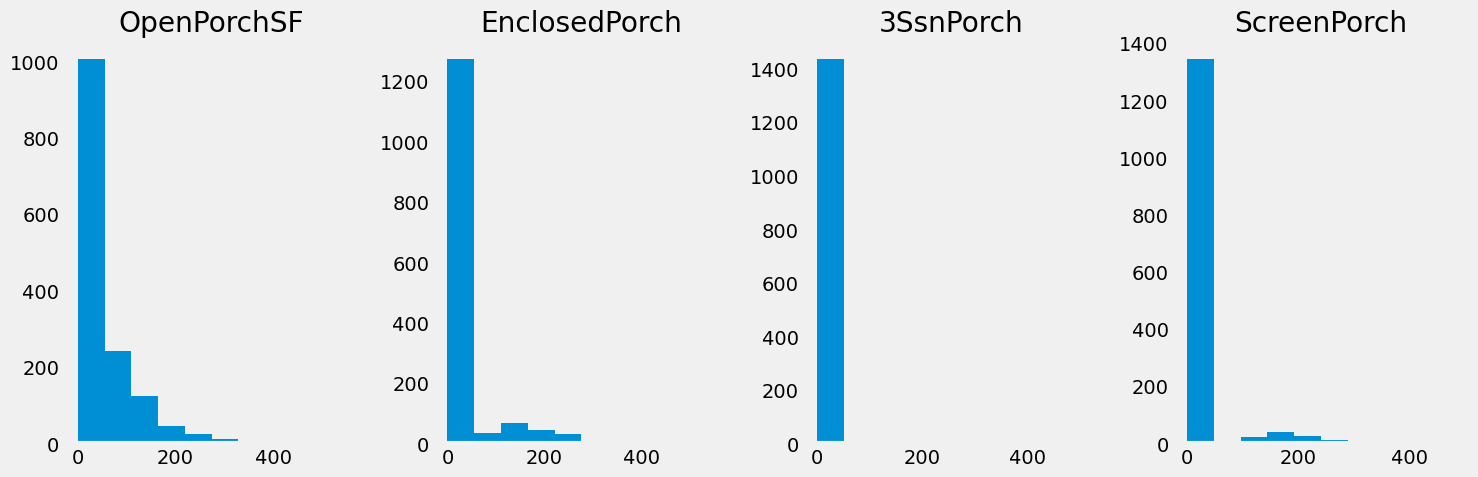

In [326]:
plot_hist_per_columns(df_train, porch_cols)

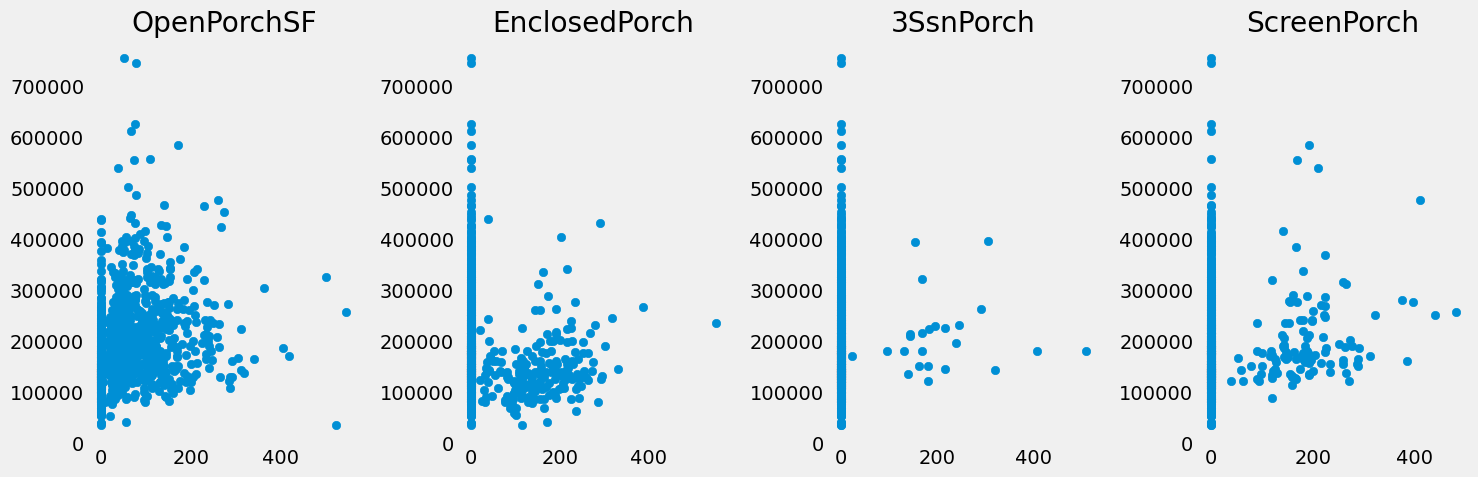

In [327]:
plot_scatter_per_columns(df_train, porch_cols)

Se decide eliminar "EnclosedPorch" y "ScreenPorch"

In [328]:
df_train_2 = df_train.drop(porch_cols[1:], axis=1)
df_train_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [329]:
df_train_2_numerics = df_train_2.select_dtypes(include=np.number)
df_train_2_numerics.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))

SalePrice       1.00000
OverallQual     0.79098
GrLivArea       0.70862
GarageCars      0.64041
GarageArea      0.62343
TotalBsmtSF     0.61358
1stFlrSF        0.60585
FullBath        0.56066
TotRmsAbvGrd    0.53372
YearBuilt       0.52290
YearRemodAdd    0.50710
GarageYrBlt     0.48636
MasVnrArea      0.47749
Fireplaces      0.46693
BsmtFinSF1      0.38642
LotFrontage     0.35180
WoodDeckSF      0.32441
2ndFlrSF        0.31933
OpenPorchSF     0.31586
HalfBath        0.28411
LotArea         0.26384
BsmtFullBath    0.22712
BsmtUnfSF       0.21448
BedroomAbvGr    0.16821
PoolArea        0.09240
MoSold          0.04643
BsmtFinSF2     -0.01138
BsmtHalfBath   -0.01684
MiscVal        -0.02119
Id             -0.02192
LowQualFinSF   -0.02561
YrSold         -0.02892
OverallCond    -0.07786
MSSubClass     -0.08428
KitchenAbvGr   -0.13591
Name: SalePrice, dtype: float64

### Analisis Variables Normales

In [330]:
vanilla_normal_cols = []
for col in df_train_2_numerics.columns:
    if shapiro_wilk_test(df_train_2_numerics[col], print_results = False):
        vanilla_normal_cols.append(col)
print(*vanilla_normal_cols, sep="\n")

LotFrontage
MasVnrArea
GarageYrBlt


In [331]:
df_train_vanilla_normals = df_train_2_numerics[vanilla_normal_cols + ["SalePrice"]]
df_train_vanilla_normals.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))

SalePrice      1.00000
GarageYrBlt    0.48636
MasVnrArea     0.47749
LotFrontage    0.35180
Name: SalePrice, dtype: float64

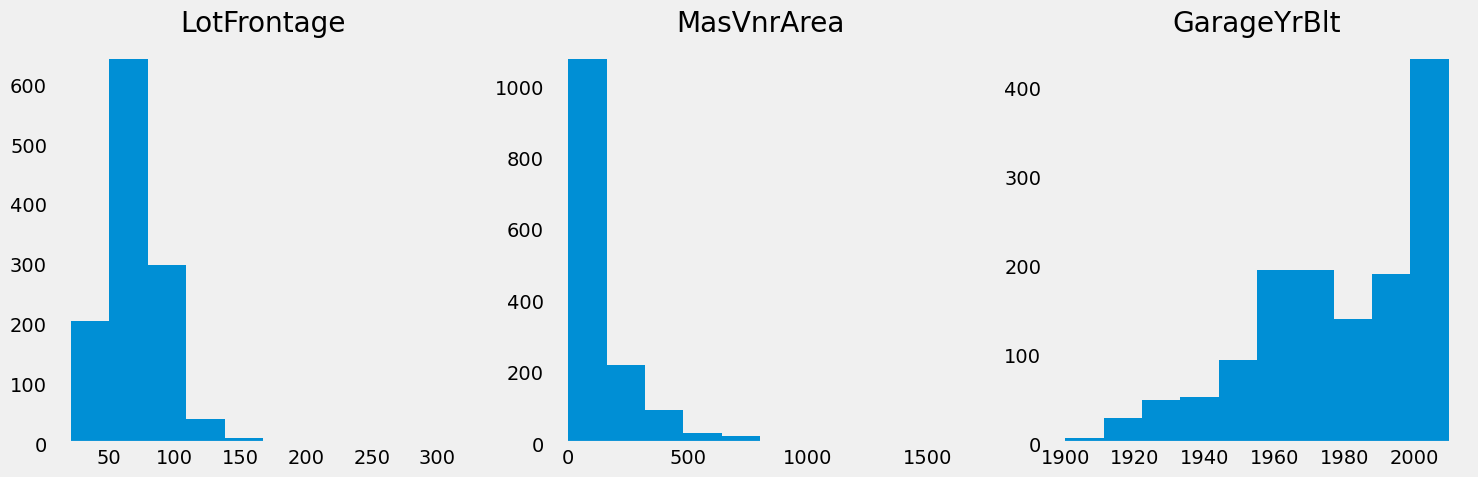

In [332]:
plot_hist_per_columns(df_train_vanilla_normals, vanilla_normal_cols)

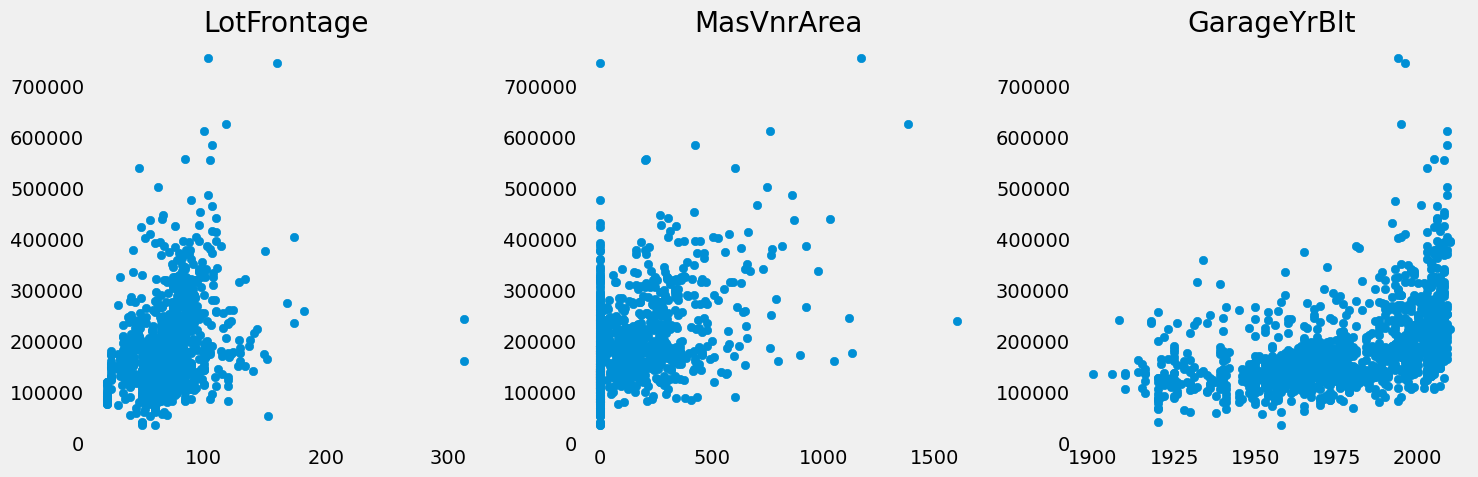

In [333]:
plot_scatter_per_columns(df_train_vanilla_normals, vanilla_normal_cols)

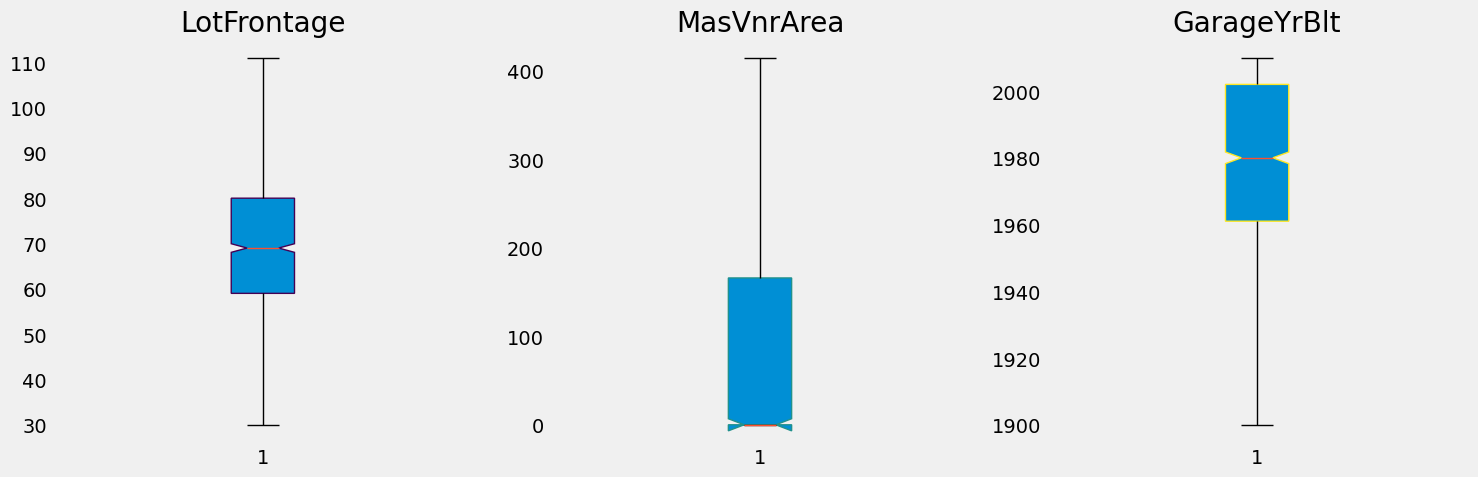

In [334]:
plot_box_per_columns(df_train_vanilla_normals, vanilla_normal_cols)